# ViT from scratch, step by step

In [2]:
import os
import sys
from pathlib import Path

repo_root = os.path.abspath(os.path.join(os.path.dirname("__file__"), '..'))
core_path = os.path.join(repo_root, 'core')
if repo_root not in sys.path:
    sys.path.append(repo_root)
    
if core_path not in sys.path:
    sys.path.append(core_path)
    
# set auto reaload of modules
%load_ext autoreload
%autoreload 2

%matplotlib inline

Check torch version:

In [3]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except Exception as e:
    print(f"[INFO] Error: {e}")
    print("[INFO] torch/torchvision versions not as required, installing nightly versions.")
    %pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.8.0+cu128
torchvision version: 0.23.0+cu128


Check that `torchinfo` is installed + import the necessary code:

In [4]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from core import data_setup, engine
from core.utils import download_data, set_seeds, plot_loss_curves

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except ImportError:
    print("[INFO] Couldn't find torchinfo... installing it.")
    %pip install -q torchinfo
    from torchinfo import summary

/home/lucamodica/stuff/vit-from-scratch/.venv/lib/python3.13/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/home/lucamodica/stuff/vit-from-scratch/.venv/lib/python3.13/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [8]:
# Setup seed for reproducibility
set_seeds()

## Get Data

In [6]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find ../data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('../data/pizza_steak_sushi')

In [7]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

## Datasets and DataLoaders

From the paper (table 3):
- training img dim = 224
- batch size = 4096

In [10]:
from torchvision import transforms

IMG_DIM = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_DIM, IMG_DIM)),
    transforms.ToTensor(),
])

In [13]:
BATCH_SIZE = 32 # <-- cuz of hw limits lol
NUM_WORKERS = 4

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transforms=manual_transforms,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)

train_dataloader, test_dataloader, class_names

Class names: ['pizza', 'steak', 'sushi']


(<torch.utils.data.dataloader.DataLoader at 0x7036075ff4d0>,
 ['pizza', 'steak', 'sushi'])

/home/lucamodica/stuff/vit-from-scratch/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


torch.Size([3, 224, 224]) tensor(1)


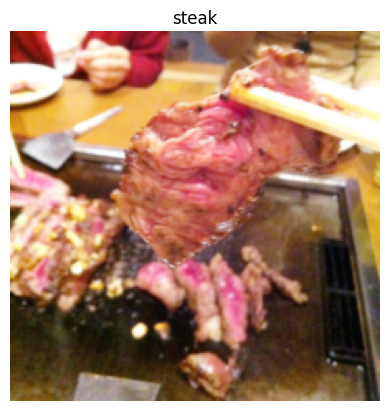

In [50]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# rearrange image dimensions to suit matplotlib 
# [color_channels, height, width] -> [height, width, color_channels]
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

## Implementation AAAAA

Main equations:
$$
\begin{aligned}
\mathbf{z}_0 & =\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^2 \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D} \\
\mathbf{z}_{\ell}^{\prime} & =\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)+\mathbf{z}_{\ell-1},\right. & & \ell=1 \ldots L \\
\mathbf{z}_{\ell} & =\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, \\
\mathbf{y} & =\operatorname{LN}\left(\mathbf{z}_L^0\right) & &
\end{aligned}
$$

### Equation 1

let's calculate how many patches we would get, considering we will replicate the base version of ViT.

In [51]:
H = 224  # height
W = 224  # width
P = 16   # patch size
C = 3    # number of channels (RGB)
N = (H * W) // (P * P)  # number of patches

print(f"Number of patches: {N}")

Number of patches: 196


translated into the dimensions of our input (the image itself) and the output (the flattened/patched version):

In [52]:
image_shape = (H, W, 3)  # assuming 3 color channels (RGB)
patch_size = (N, (P**2 * C))

print("Input shape (the image itself):", image_shape)
print("Output shape (the flattened/patched version):", patch_size)

Input shape (the image itself): (224, 224, 3)
Output shape (the flattened/patched version): (196, 768)


#### Turning the image into patches

plain image

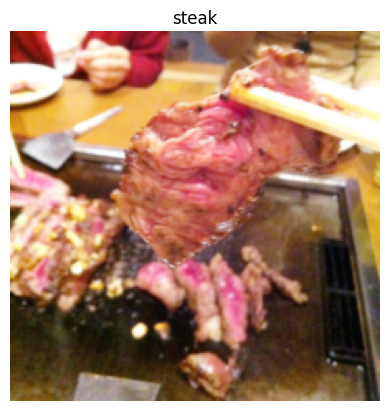

In [53]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

top row of patched pixels

(np.float64(-0.5), np.float64(223.5), np.float64(15.5), np.float64(-0.5))

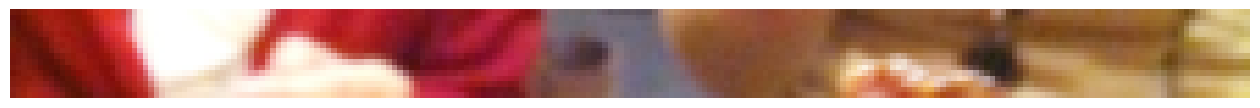

In [54]:
img_permuted = image.permute(1, 2, 0)  # [H, W, C]

plt.figure(figsize=(P, P))
plt.imshow(img_permuted[:P, :, :])  # top-left patch
plt.axis(False)

let's patchify the top row:

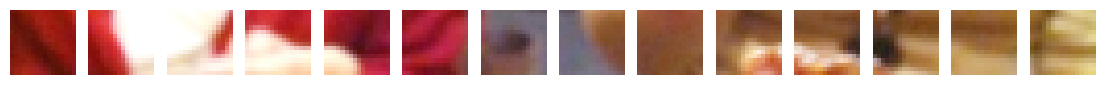

In [55]:
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image dimensions must be divisible by the patch size."

fig, axs = plt.subplots(
    nrows=1,
    ncols=int(num_patches), 
    figsize=(num_patches, 1)
)

for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(img_permuted[:patch_size, patch:patch+patch_size, :])
    axs[i].axis(False)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Let's do it for the whole image

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


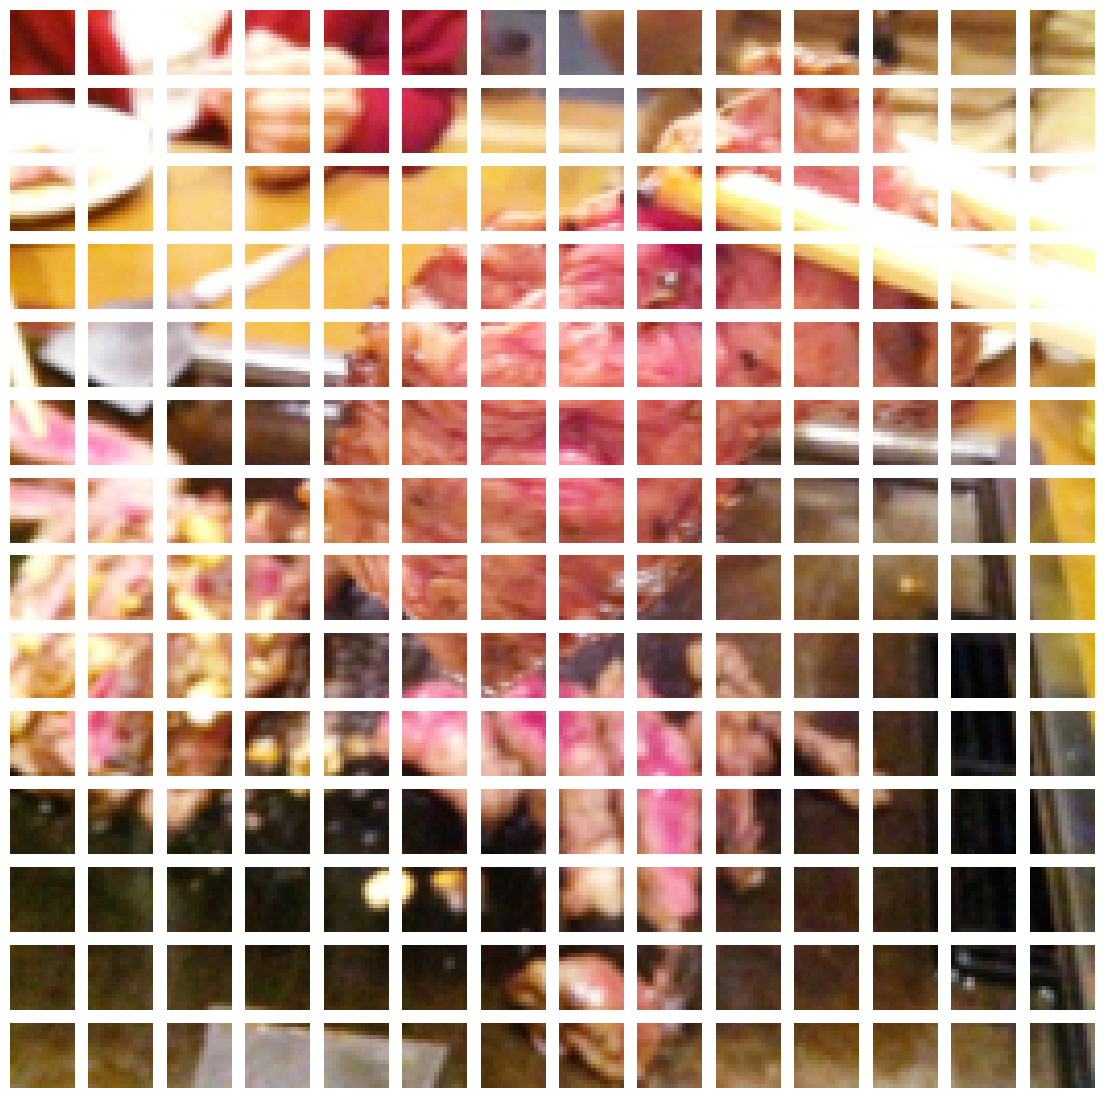

In [56]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(
    nrows= img_size // patch_size,
    ncols= img_size // patch_size,
    figsize=(num_patches, num_patches),
    sharex=True,
    sharey=True
)

for i, row in enumerate(range(0, img_size, patch_size)):
    for j, col in enumerate(range(0, img_size, patch_size)):
        axs[i, j].imshow(img_permuted[row:row+patch_size, col:col+patch_size, :])
        axs[i, j].axis(False)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

### Creating image patches using `Conv2D`